# Pastas Metran example

Reproduces results in article  van Geer and Berendrecht in Stromingen 23 (2015).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps
import metran

ps.logger.setLevel("ERROR")

## Read data

In [2]:
oseries = {}
ofiles = [os.path.join("./data", f) for f in os.listdir("./data") if f.endswith("_1.csv")]

for fi in ofiles:
    name = fi.split(os.sep)[-1].split(".")[0].split("_")[0]
    o = ps.read_dino(fi)
    # remove outliers outside 5*std
    mean = o.series_original.median()
    std = o.series_original.std()
    mask_outliers = ((o.series_original - mean).abs() > 5*std)
    ts = o.series_original.copy()
    ts.loc[mask_outliers] = np.nan
    o = ps.TimeSeries(ts, settings="oseries", metadata=o.metadata)
    oseries[name] = o

In [3]:
residuals = {}
rfiles = [os.path.join("./data", f) for f in os.listdir("./data") if f.endswith("_res.csv")]

for fi in rfiles:
    name = fi.split(os.sep)[-1].split(".")[0].split("_")[0]
    ts = pd.read_csv(fi, header=0, index_col=0, parse_dates=True, 
                     infer_datetime_format=True,dayfirst=True)
    residuals[name] = ts

In [4]:
sorted_names = list(oseries.keys())
sorted_names.sort()
sorted_names

['B21B0214001', 'B21B0214002', 'B21B0214003', 'B21B0214004', 'B21B0214005']

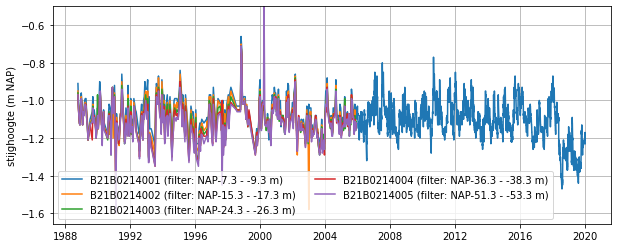

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for name in sorted_names:
    o = oseries[name]
    ftop = float(o.metadata["Bovenkant filter (cm t.o.v. NAP)"]) / 100.
    fbot = float(o.metadata["Onderkant filter (cm t.o.v. NAP)"]) / 100.
    lbl = f"{name} (filter: NAP{ftop:+.1f} - {fbot:+.1f} m)"
    ax.plot(o.series_original.index, o.series_original, label=lbl)

ax.set_ylabel("stijghoogte (m NAP)")
ax.legend(loc='best', ncol=2)
ax.set_ylim(top=-0.5)
ax.grid(b=True)

In [6]:
p = pd.read_csv("./data/RD_338.csv", index_col=[0], parse_dates=True, usecols=["YYYYMMDD", "RD"])
e = pd.read_csv("./data/EV24_260.csv", index_col=[0], parse_dates=True, usecols=["YYYYMMDD", "EV24"])

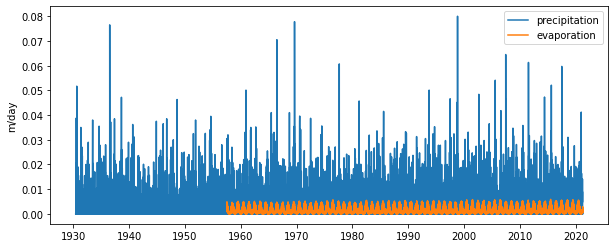

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(p.index, p, label="precipitation")
ax.plot(e.index, e, label="evaporation")
ax.set_ylabel("m/day")
ax.legend(loc="best");

## Build timeseries models

In [8]:
p.index = p.index.normalize()
e.index = e.index.normalize()

In [9]:
models = []

for name in sorted_names:
    ml = ps.Model(oseries[name])
    rm = ps.RechargeModel(prec=p, evap=e)
    ml.add_stressmodel(rm)
    ml.solve(report=False)
    models.append(ml)


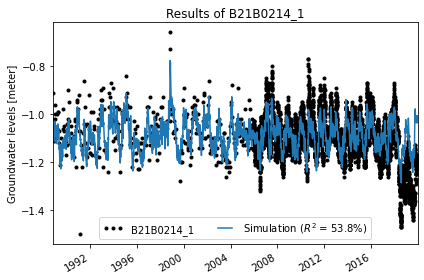

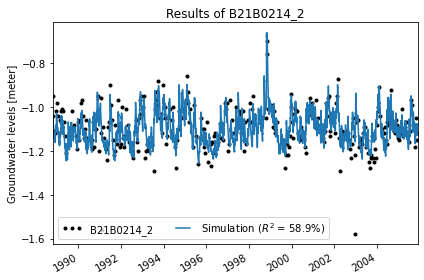

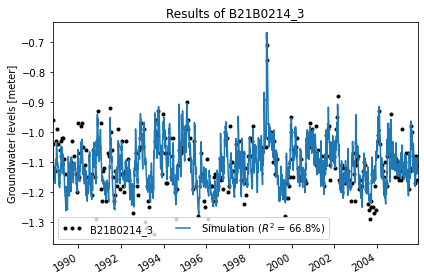

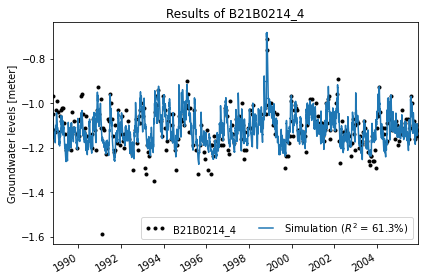

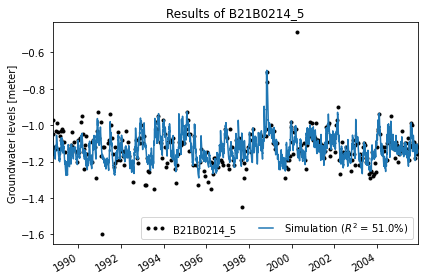

In [10]:
for ml in models:
    ml.plot()

## Metran

In [27]:
series = []

for name in sorted_names:
    ts = residuals[name]
    ts.columns = [name]
    series.append(ts)

In [28]:
mt = metran.Metran(series, name="B21B0214")
mt.solve()


INFO: Number of factors according to Velicer's MAP test: 1

Fit report B21B0214        Fit Statistics
tmin     None             obj     2332.33
tmax     None             nfev    77
freq     D                AIC     2344.33
solver   ScipySolve               

Parameters (6 were optimized)
            optimal   stderr initial  vary
sdf1_alpha  5.50114  ±18.89%      10  True
sdf2_alpha  13.5599  ±10.01%      10  True
sdf3_alpha  4.68276  ±28.80%      10  True
sdf4_alpha  11.3818  ±18.26%      10  True
sdf5_alpha  13.1406   ±8.45%      10  True
cdf1_alpha  22.9811   ±7.42%      10  True

Parameter correlations |rho| > 0.5
None

Metran report B21B0214       Factor Analysis
tmin     None                nfct    1
tmax     None                fep     88.32%
freq     D                            

Communality
                   
B21B0214001  73.61%
B21B0214002  87.59%
B21B0214003  93.35%
B21B0214004  91.74%
B21B0214005  81.15%

State parameters
                  phi         q
sdf1         0.833

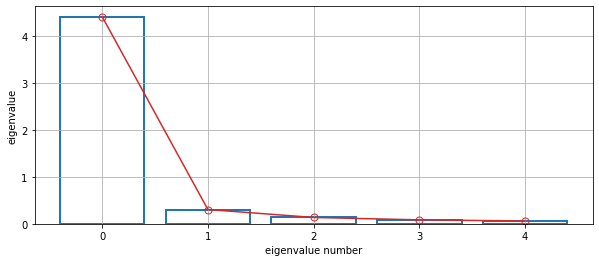

In [29]:
# Get eigenvalues (can be used to plot scree plot, see e.g. Fig 2 in JoH paper)

n_ev = np.arange(mt.eigval.shape[0])
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(n_ev, mt.eigval, marker="o", ms=7, mfc="none", c="C3")
ax.bar(n_ev, mt.eigval, facecolor="none", edgecolor="C0", linewidth=2)
ax.grid(b=True)
ax.set_ylabel("eigenvalue")
ax.set_xlabel("eigenvalue number");

In [38]:
# Get all smoothed state means
states = mt.get_state_means()


AttributeError: 'DataFrame' object has no attribute 'colums'

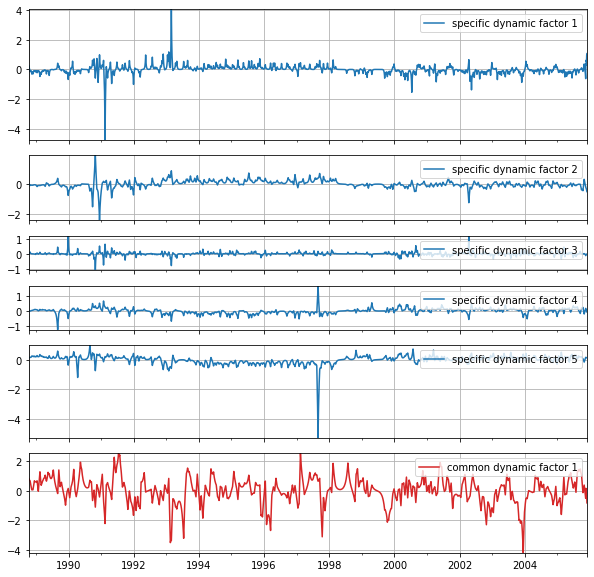

In [58]:
adjust_height = True
tmin = states.index[0]
tmax = states.index[-1]

ylims = []

if adjust_height:
    for s in states:
        hs = states.loc[tmin:tmax, s]
        if hs.empty:
            if s.empty:
                ylims.append((0.0, 0.0))
            else:
                ylims.append((s.min(), hs.max()))
        else:
            ylims.append((hs.min(), hs.max()))
    hrs = ps.plots._get_height_ratios(ylims)
else:
    hrs = [1] * (states.columns.size)

fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(ncols=1, nrows=states.columns.size, height_ratios=hrs)

for i, col in enumerate(states.columns):
    if i == 0:
        iax = fig.add_subplot(gs[i])
        ax0 = iax
    else:
        iax = fig.add_subplot(gs[i], sharex=ax0)
    
    if col.startswith("cdf"):
        c = "C3"
        lbl = f"common dynamic factor {col[3:]}"
    else:
        c = "C0"
        lbl = f"specific dynamic factor {col[3:]}"
    
    states.loc[:, col].plot(ax=iax, label=lbl, color=c)
    iax.legend(loc="upper right")
    iax.grid(b=True)
    
    if adjust_height:
        iax.set_ylim(ylims[i])

iax.set_xlabel("");

In [31]:
# Get all (smoothed) projected state means
means = mt.get_projected_means()
means

,B21B0214001,B21B0214002,B21B0214003,B21B0214004,B21B0214005
date,,,,,
1988-10-14,5.451924,4.335813,4.621265,4.673373,5.502840
1988-10-15,5.096049,4.187863,4.501912,4.548265,5.371573
1988-10-16,4.783655,4.048102,4.397629,4.432550,5.254124
1988-10-17,4.507198,3.916095,4.307919,4.325911,5.150200
1988-10-18,4.260093,3.791424,4.232600,4.228053,5.059554
...,...,...,...,...,...
2005-11-24,4.611924,-2.957738,-0.966455,-0.862405,-0.022862
2005-11-25,4.101924,-3.818555,-1.713013,-1.716161,-0.780055
2005-11-26,3.761924,-4.699607,-2.473304,-2.578912,-1.540611


<AxesSubplot:xlabel='date'>

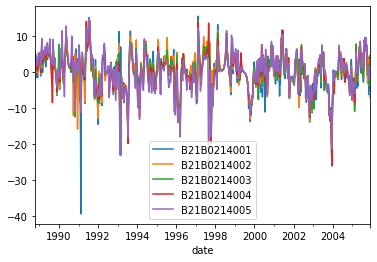

In [59]:
means.plot()

In [32]:
# Get projected mean for specific series with/without confidence interval
name = "B21B0214005"
proj = mt.get_projection(name, ci=True)
proj

,mean,lower,upper
date,,,
1988-10-14,5.502840,5.502840,5.502840
1988-10-15,5.371573,1.692736,9.050411
1988-10-16,5.254124,0.296314,10.211935
1988-10-17,5.150200,-0.617491,10.917891
1988-10-18,5.059554,-1.240740,11.359848
...,...,...,...
2005-11-24,-0.022862,-5.193024,5.147299
2005-11-25,-0.780055,-5.527965,3.967856
2005-11-26,-1.540611,-5.647204,2.565982


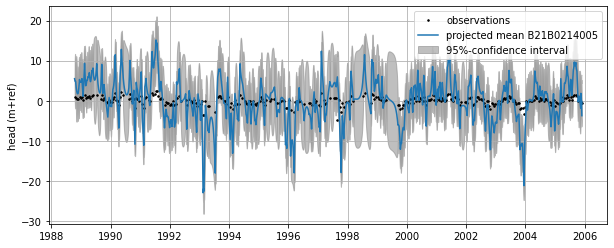

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# o = mt.oseries[name]
# ax.plot(o.index, o, marker=".", ms=3, color="k", ls='none', label="observations")
ax.plot(proj.index, proj["mean"], label=f"projected mean {name}")
ax.fill_between(proj.index, proj["lower"], proj["upper"], color="gray", 
                alpha=0.5, label="95%-confidence interval")
ax.legend(loc="best")
ax.grid(b=True)
ax.set_ylabel("head (m+ref)");

In [65]:
# Decomposed projected mean for specific series
dec = mt.decompose_projection("B21B0214001")
dec

,sdf,cdf
date,,
1988-10-14,1.341284,4.110640
1988-10-15,1.082866,4.013183
1988-10-16,0.860329,3.923326
1988-10-17,0.666299,3.840899
1988-10-18,0.494347,3.765746
...,...,...
2005-11-24,5.384510,-0.772586
2005-11-25,5.567321,-1.465397
2005-11-26,5.927577,-2.165653


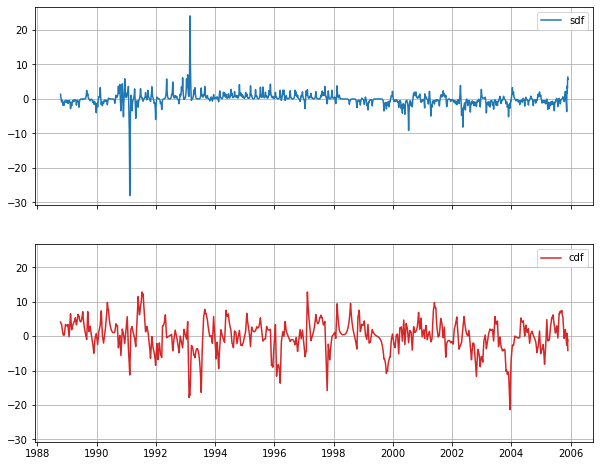

In [73]:
adjust_height = False

fig, axes = plt.subplots(dec.columns.size, 1, figsize=(10, 8), sharex=True, sharey=True)

for i, col in enumerate(dec.columns):
    if col.startswith("cdf"):
        c = "C3"
    else:
        c = "C0"
    iax = axes.flat[i]
    s = dec[col]
    iax.plot(s.index, s, label=col, color=c)
    iax.grid(b=True)
    iax.legend(loc="upper right")

In [74]:
# Get specific state mean with/without confidence interval
mt.get_state(0, ci=True)

,mean,lower,upper
date,,,
1988-10-14,0.226548,-0.393873,0.846969
1988-10-15,0.182900,-0.577906,0.943707
1988-10-16,0.145313,-0.697829,0.988455
1988-10-17,0.112541,-0.781191,1.006272
1988-10-18,0.083497,-0.840717,1.007711
...,...,...,...
2005-11-24,0.909465,0.287592,1.531338
2005-11-25,0.940343,0.358316,1.522369
2005-11-26,1.001192,0.479222,1.523162


INFO: Running Kalman filter with masked observations.


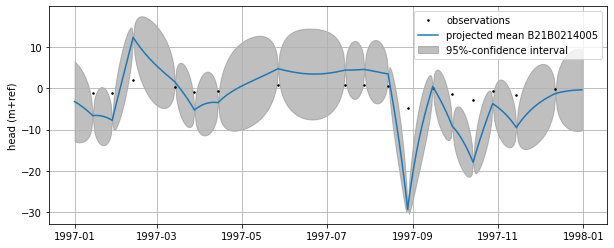

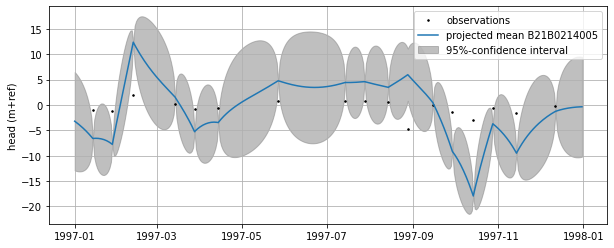

In [82]:
# remove outlier from series B21B0214005 at 1997-8-28
# and re-run smoother to get estimate of observation
# (Fig 3 in Stromingen without deterministic component)
name = "B21B0214005"
proj = mt.get_projection(name, ci=True)

proj = proj.loc["1997"]

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

o = mt.oseries[name].loc["1997"]
ax.plot(o.index, o, marker=".", 
        ms=3, color="k", ls='none', label="observations")
ax.plot(proj.index, proj["mean"], label=f"projected mean {name}")
ax.fill_between(proj.index, proj["lower"], proj["upper"], color="gray", 
                alpha=0.5, label="95%-confidence interval")
ax.legend(loc="best")
ax.grid(b=True)
ax.set_ylabel("head (m+ref)");

oseries = mt.get_observations()
mask = (0 * oseries).astype(bool)
mask.loc["1997-8-28", "B21B0214005"] = True
mt.mask_observations(mask)
proj2 = mt.get_projection("B21B0214005", ci=True)

proj2 = proj2.loc["1997"]

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

o = mt.oseries[name].loc["1997"]
ax.plot(o.index, o, marker=".", 
        ms=3, color="k", ls='none', label="observations")
ax.plot(proj2.index, proj2["mean"], label=f"projected mean {name}")
ax.fill_between(proj2.index, proj2["lower"], proj2["upper"], color="gray", 
                alpha=0.5, label="95%-confidence interval")
ax.legend(loc="best")
ax.grid(b=True)
ax.set_ylabel("head (m+ref)");

# unmask observations to get original observations
mt.unmask_observations()